In [ ]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from scipy.special import expit

from ampligraph.datasets import load_wn11
from ampligraph.latent_features.models import TransE, ComplEx, DistMult

In [2]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso
import types

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
X = load_wn11()

In [5]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [ ]:
results = []

for eta in [1, 5, 10, 20, 50, 100]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=100, eta=eta,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'eta': eta,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

In [7]:
eta_results = results

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
df=pd.DataFrame(eta_results)
df.columns

Index(['eta', 'brier_score_scores', 'log_loss_scores',
       'brier_score_probas_pos', 'log_loss_probas_pos',
       'brier_score_probas_pos_neg', 'log_loss_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'log_loss_probas_pos_neg_iso',
       'brier_score_probas_pos_iso', 'log_loss_probas_pos_iso',
       'brier_score_probas_pos_sc', 'log_loss_probas_pos_sc',
       'brier_score_probas_pos_neg_sc', 'log_loss_probas_pos_neg_sc',
       'ece_scores', 'ece_probas_pos', 'ece_probas_pos_neg',
       'ece_probas_pos_neg_iso', 'ece_probas_pos_iso', 'ece_probas_pos_sc',
       'ece_probas_pos_neg_sc', 'metrics_mrr', 'metrics_hits@10', 'metrics_mr',
       'accuracy_per_relation', 'accuracy_uncalib', 'accuracy_pos',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_iso',
       'accuracy_pos_sc', 'accuracy_pos_neg_sc'],
      dtype='object')

In [80]:
df.to_csv("wn11_eta.csv", index=False)

Text(0.5, 1.0, 'WN11')

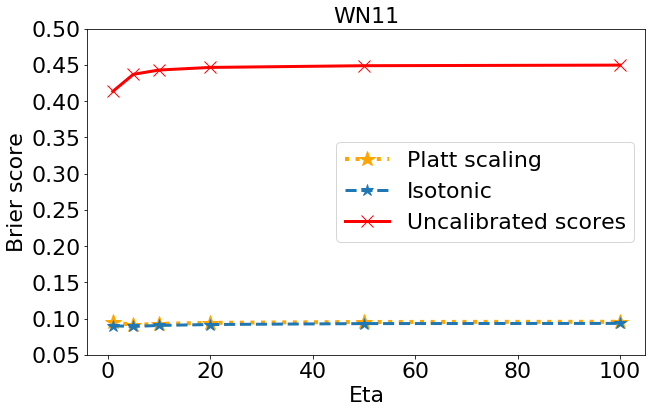

In [81]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})

fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.eta, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.eta, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.eta, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Eta")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.eta, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2])

# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)
ax1.legend()

plt.title("WN11")

In [ ]:
results = []

for k in [10, 25, 50, 100, 200, 500]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=k, eta=20,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'k': k,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

In [14]:
k_results = results

In [75]:
df=pd.DataFrame(k_results)
df.columns

Index(['k', 'brier_score_scores', 'log_loss_scores', 'brier_score_probas_pos',
       'log_loss_probas_pos', 'brier_score_probas_pos_neg',
       'log_loss_probas_pos_neg', 'brier_score_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_iso', 'brier_score_probas_pos_iso',
       'log_loss_probas_pos_iso', 'brier_score_probas_pos_sc',
       'log_loss_probas_pos_sc', 'brier_score_probas_pos_neg_sc',
       'log_loss_probas_pos_neg_sc', 'ece_scores', 'ece_probas_pos',
       'ece_probas_pos_neg', 'ece_probas_pos_neg_iso', 'ece_probas_pos_iso',
       'ece_probas_pos_sc', 'ece_probas_pos_neg_sc', 'metrics_mrr',
       'metrics_hits@10', 'metrics_mr', 'accuracy_per_relation',
       'accuracy_uncalib', 'accuracy_pos', 'accuracy_pos_neg',
       'accuracy_pos_neg_iso', 'accuracy_pos_iso', 'accuracy_pos_sc',
       'accuracy_pos_neg_sc'],
      dtype='object')

In [76]:
df.to_csv("wn11_k.csv", index=False)

Text(0.5, 1.0, 'WN11')

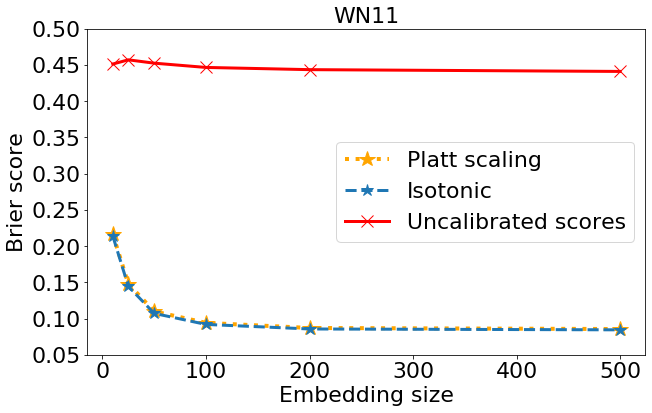

In [78]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})
fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.k, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.k, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.k, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Embedding size")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.k, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2])

# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)
ax1.legend()

plt.title("WN11")